## improve the linear approximator with SARSA-lambda
- we will implement something similar to TD-lambda described in p. 257 on Sutton's book

### Eligibility Trace
- motivation: forward vs. backwards (online)
- accumulating:
- dutch traces:

### hyperparameters
- lambda

### reference
- https://gym.openai.com/evaluations/eval_DAj7EdpYTiO7m0H1f6xWw

In [1]:
import gym
import itertools
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import sys

import sklearn.pipeline
import sklearn.preprocessing
import os
from gym import wrappers

if "../../" not in sys.path:
  sys.path.append("../../")

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

from abc import ABCMeta, abstractmethod

class Estimator(metaclass=ABCMeta):
    @abstractmethod
    def featurize(self): pass

    @abstractmethod
    def predict(self): pass

    @abstractmethod
    def update(self): pass

def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
#        print(q_values)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def sarsa_lambda(env, estimator, num_episodes, num_timesteps, gamma=1.0, epsilon=0.1, epsilon_decay=0.1, lambd=0.1):
    """
    implement a vanilla semi-gradient SARSA-lambda
    it's crude, but this should outperform q-learning TD(0)
    """
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    for i_episode in range(num_episodes):
        # print("episode: ", i_episode)
        # initialize

        policy = make_epsilon_greedy_policy(
            estimator, epsilon, env.action_space.n)

        estimator.initialize_eligibility()

        s = env.reset()
        rAll = 0

        # pick the first action
        probs = policy(s)
        a = np.random.choice(np.arange(len(probs)), p=probs)
        Q = estimator.predict(s, a)

        for t in range(num_timesteps):
            next_s, r, done, _ = env.step(a)

            # update eligibility
            estimator.update_eligibility(s, a, gamma, lambd)
            
            if done:
                td_target = r
            else:
                next_probs = policy(next_s)
                next_a = np.random.choice(np.arange(len(next_probs)), p=next_probs)
                next_Q = estimator.predict(next_s, next_a)
                td_target = r + gamma * next_Q

            td_delta = td_target - Q

            estimator.update(s, a, td_delta)
            
            rAll += r
            s = next_s
            a = next_a
            Q = next_Q
            
            epsilon *= epsilon_decay
            
            if done:
                break

        stats.episode_rewards[i_episode] = rAll
        stats.episode_lengths[i_episode] = t
    return stats

class Linear_Regressor(Estimator):
    """
    we are estimating Q(s, a) for each action.
    note we're maintaining a different regressor(Theta) for each action.
    we could have include action in the input itself and maintain one model.
    But this way seems much easier to implement.

    therefore:
    input: (1, num_features)
    params: Theta (num_features, num_actions)
    output: input * params = (1, num_actions)
    """
    def __init__(self, num_features, num_actions, standardizer, phi, alpha=0.05):
        super(Linear_Regressor, self).__init__()
        self.n = num_features
        self.nA = num_actions
        self.Theta = np.zeros((self.n, self.nA))
        self.E = np.zeros((self.n, self.nA)) # eligibility trace
        self.phi = phi
        self.standardizer = standardizer
        self.alpha = alpha

    def featurize(self, state):
        # scaled = self.standardizer.transform([state])
        # X = self.phi.transform(scaled)[0]
        s = self.standardizer(state)
        X = self.phi(s)
        return np.array(X)

    def predict(self, s, a=None):
        X = self.featurize(s)
        if a is not None:
            ret = np.matmul(X, self.Theta[:, a])
        else:
            ret = np.matmul(X, self.Theta)
        return ret

    def update(self, s, a, td_delta):
        # semi-gradient update, as td_delta does bootstraping
        delta = self.alpha * td_delta * self.E[:, a]
        self.Theta[:, a] += delta
        # print(self.Theta[1, :])

    def calulcate_gradient(self, s, a):
        # really crube way of calculating gradient.
        grad = self.featurize(s)
        return grad

    def update_eligibility(self, s, a, gamma, lambd):
        """
        eligibility trace = accumulating credit assignment matrix
        we add credit to Theta[k, a] by the amount Theta[k, a]
        contributes to Q[s, a, Theta] (gradient)
        we add more credit to the recent assignment
        """
        grad = self.calulcate_gradient(s, a)
        self.E *= gamma * lambd # recency
        self.E[:, a] += grad # frequency accumulating
        #self.E[:, a] = grad # frequency replacing
        # print("eligibility updated: {}".format(self.E))

    def initialize_eligibility(self):
        self.E = np.zeros((self.n, self.nA))
        # print("e initialized: {}".format(self.E))

def is_solved(stats, target, interval):
    """
    checks if openai's criteria has been met
    """
    # FrozenLake-v0 is considered "solved" when the agent
    # obtains an average reward of at least 0.78 over 100
    # consecutive episodes.
    avg_reward = np.sum(stats.episode_rewards)/len(stats.episode_rewards)
    print("Average reward : {}".format(avg_reward))

    def moving_avg(x, n=100):
        return np.convolve(x, np.ones((n,))/n, mode='valid')

    ma = moving_avg(stats.episode_rewards, interval)
    peaks = np.where(ma > target)[0]
    if len(peaks) > 0:
        print("solved after {} episodes".format(peaks[0]))
        return True
    else:
        print("did not pass the openai criteria")
        return False


[2017-03-23 20:53:11,677] Making new env: MountainCar-v0
[2017-03-23 20:53:11,713] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-23 20:53:11,715] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-03-23 20:56:22,385] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/mtcar-experiment-v1')
[2017-03-23 20:56:22,393] [MountainCar-v0] Uploading 700 episodes of training data


Average reward : -132.21857142857144
solved after 584 episodes


[2017-03-23 20:56:25,081] [MountainCar-v0] Creating evaluation object from /tmp/mtcar-experiment-v1 with learning curve
[2017-03-23 20:56:30,841] 
****************************************************
You successfully uploaded your evaluation on MountainCar-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_YMgLRCi1R3SUYbvKDhuKMA

****************************************************


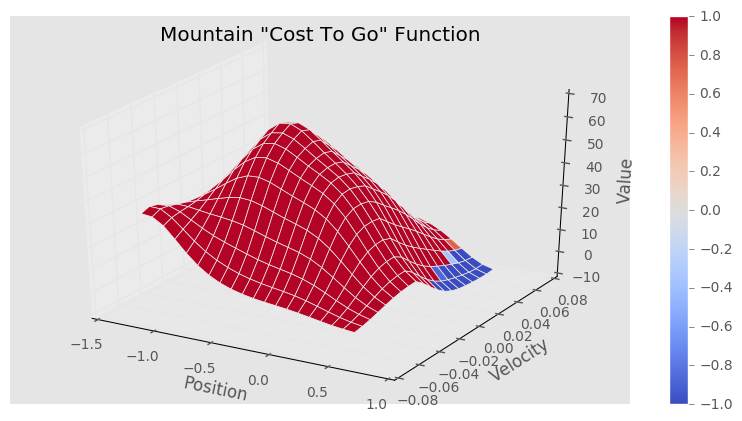

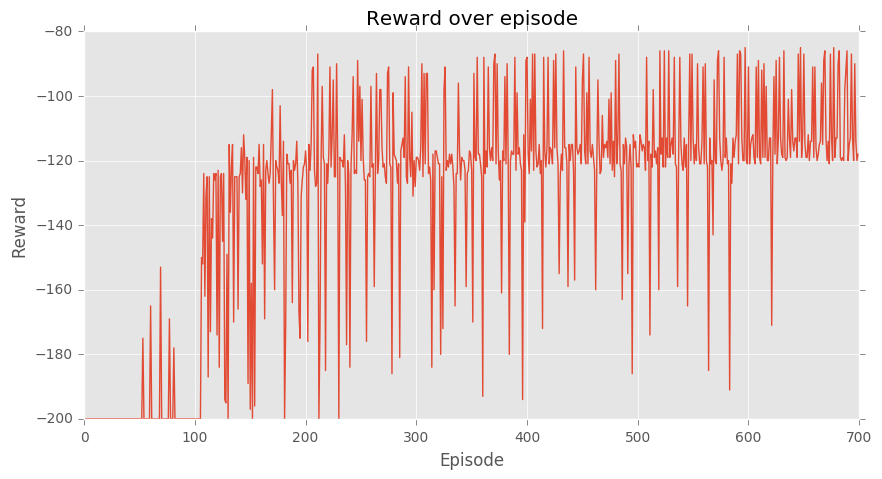

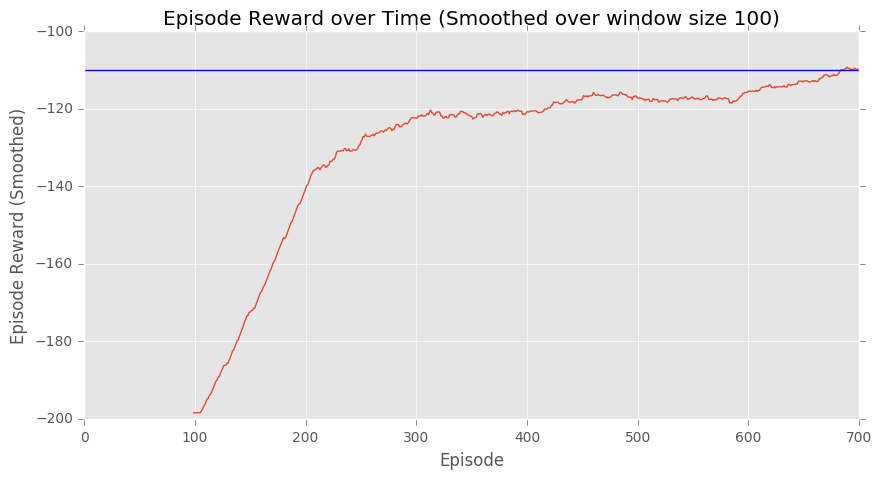

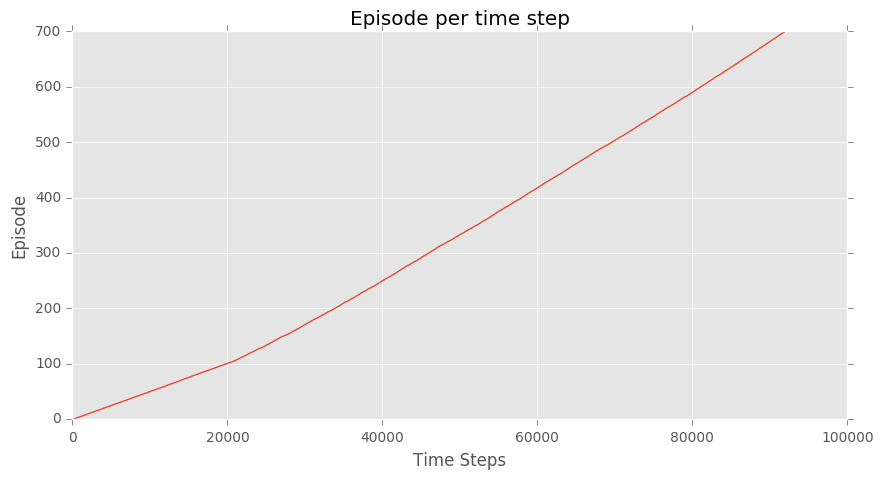

(<matplotlib.figure.Figure at 0x1098dde80>,
 <matplotlib.figure.Figure at 0x10a58bba8>)

In [2]:
env = gym.envs.make("MountainCar-v0")
env = wrappers.Monitor(env, '/tmp/mtcar-experiment-v1', force=True, video_callable=False)

nA = env.action_space.n

dim = env.observation_space.high.size
num_rbf = 4 * np.ones(nA).astype(int)
width = 1. / (num_rbf - 1.)
rbf_sigma = width[0] / 2.
xbar = np.zeros((2, dim))
xbar[0, :] = env.observation_space.low
xbar[1, :] = env.observation_space.high
num_ind = np.prod(num_rbf)


rbf_den = 2 * rbf_sigma ** 2
# Construct ndarray of rbf centers
c = np.zeros((num_ind, dim))
for i in range(num_rbf[0]):
    for j in range(num_rbf[1]):
        c[i*num_rbf[1] + j, :] = (i * width[1], j * width[0])

# Returns the state scaled between 0 and 1
def normalize_state(_s):
    _y = np.zeros(len(_s))
    for _i in range(len(_s)):
        _y[_i] = (_s[_i] - xbar[0, _i]) / (xbar[1, _i] - xbar[0, _i])
    return _y

def phi(_state):
    _phi = np.zeros(num_ind)
    for _k in range(num_ind):
        _phi[_k] = np.exp(-np.linalg.norm(_state - c[_k, :]) ** 2 / rbf_den)
    return _phi

num_episodes = 700
epsilon = 0.1
epsilon_threshold = 0.1
epsilon_decay = (epsilon - epsilon_threshold) ** (1. / num_episodes)
estimator = Linear_Regressor(num_ind, nA, normalize_state, phi, alpha=0.01)
stats = sarsa_lambda(env, estimator, num_episodes=num_episodes, num_timesteps=200, epsilon=0.1, epsilon_decay=0.05, lambd=0.5, gamma=0.99)


TARGET_AVG_REWARD = -110.0
TARGET_EPISODE_INTERVAL = 100
env.close()
if is_solved(stats, TARGET_AVG_REWARD, TARGET_EPISODE_INTERVAL):
    OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
    gym.upload('/tmp/mtcar-experiment-v1', api_key=OPENAI_API_KEY)
    
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, goal=TARGET_AVG_REWARD)

## Tricks used to solve the env
- function approximation
- early exit at time step = 200
- eligibility trace (for online TD-lambda)
- zero epsilon
- phi with RBF (coarse or tile coding, also fine?)
- hyperparams: rbf gamma value (regularization needed)

## further thoughts
- how well would this generalize to other environments?
- Dutch tracing?
- Tile coding?
- gamma